# Polynomial chaos POD

In [1]:
# import relevant module
import openturns as ot
import otpod
# enable display figure in notebook
%matplotlib inline

## Generate 1D data

In [2]:
N = 100
ot.RandomGenerator.SetSeed(123456)
defectDist = ot.Uniform(0.1, 0.6)
# normal epsilon distribution
epsilon = ot.Normal(0, 1.9)
defects = defectDist.getSample(N)
signalsInvBoxCox = defects * 43. + epsilon.getSample(N) + 2.5
# Inverse Box Cox transformation
invBoxCox = ot.InverseBoxCoxTransform(0.3)
signals = invBoxCox(signalsInvBoxCox)

## Build POD with polynomial chaos model

In [3]:
# signal detection threshold
detection = 200.
# The POD with censored data actually builds a POD only on filtered data.
# A warning is diplayed in this case.
POD = otpod.PolynomialChaosPOD(defects, signals, detection,
                               noiseThres=200., saturationThres=1700.,
                               boxCox=True)

### User-defined defect sizes

The user-defined defect sizes must range between the minimum and
maximum of the defect values after filtering. An error is raised if 
it is not the case. The available range is then returned to the user.

In [4]:
# Default defect sizes
print 'Default defect sizes : '
print POD.getDefectSizes()

# Wrong range
POD.setDefectSizes([0.12, 0.3, 0.5, 0.57])

Default defect sizes : 
[ 0.19288542  0.21420345  0.23552149  0.25683952  0.27815756  0.29947559
  0.32079363  0.34211166  0.3634297   0.38474773  0.40606577  0.4273838
  0.44870184  0.47001987  0.49133791  0.51265594  0.53397398  0.55529201
  0.57661005  0.59792808]


ValueError: Defect sizes must range between 0.1929 and 0.5979.

In [5]:
# Good range
POD.setDefectSizes([0.1929, 0.3, 0.4, 0.5, 0.5979])
print 'User-defined defect size : '
print POD.getDefectSizes()

User-defined defect size : 
[ 0.1929  0.3     0.4     0.5     0.5979]


### Running the polynomial chaos based POD

The computing time can be reduced by setting the simulation size attribute to 
another value. However the confidence interval is less accurate.

The sampling size is the number of the samples used to compute the POD
with the Monte Carlo simulation for each defect sizes.

A progress is displayed, which can be disabled with the method *setVerbose*.

In [7]:
# Computing the confidence interval in the run takes few minutes.
POD = otpod.PolynomialChaosPOD(defects, signals, detection,
                                  boxCox=True)
# we can change the sample size of the Monte Carlo simulation
POD.setSamplingSize(2000) # default is 5000
# we can also change the size of the simulation to compute the confidence interval
POD.setSimulationSize(500) # default is 1000
# we can change the degree of the polynomial chaos, default is 3.
POD.setDegree(3)
%time POD.run()

Start build polynomial chaos model...
Polynomial chaos model completed
R2 : 0.8947
Q2 : 0.8914
Computing POD per defect: [==================================================] 100.00% Done
CPU times: user 1min 19s, sys: 576 ms, total: 1min 19s
Wall time: 1min 5s


## Compute detection size

In [8]:
# Detection size at probability level 0.9
# and confidence level 0.95
print POD.computeDetectionSize(0.9, 0.95)

# probability level 0.95 with confidence level 0.99
print POD.computeDetectionSize(0.95, 0.99)

[a90 : 0.307344, a90/95 : 0.314406]
[a95 : 0.328888, a95/99 : 0.335715]


## get POD NumericalMathFunction

In [9]:
# get the POD model
PODmodel = POD.getPODModel()
# get the POD model at the given confidence level
PODmodelCl95 = POD.getPODCLModel(0.95)

# compute the probability of detection for a given defect value
print 'POD : {:0.3f}'.format(PODmodel([0.3])[0])
print 'POD at level 0.95 : {:0.3f}'.format(PODmodelCl95([0.3])[0])

POD : 0.871
POD at level 0.95 : 0.841


## Compute the R2 and the Q2
Enable to check the quality of the model.

In [10]:
print 'R2 : {:0.4f}'.format(POD.getR2())
print 'Q2 : {:0.4f}'.format(POD.getQ2())

R2 : 0.8947
Q2 : 0.8914


## Show POD graphs
### Mean POD and POD at confidence level with the detection size for a given probability level

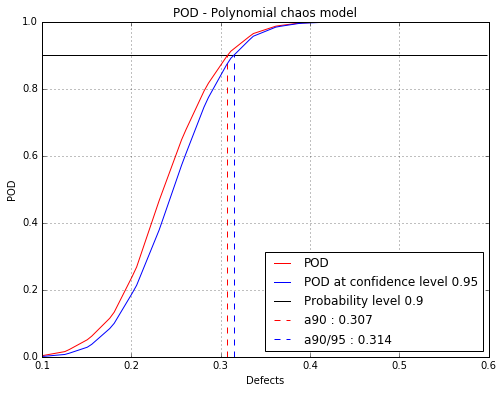

In [12]:
fig, ax = POD.drawPOD(probabilityLevel=0.9, confidenceLevel=0.95,
                      name='figure/PODPolyChaos.png')
# The figure is saved in PODPolyChaos.png
fig.show()

### Show the polynomial chaos model (only available if the input dimension is 1) 

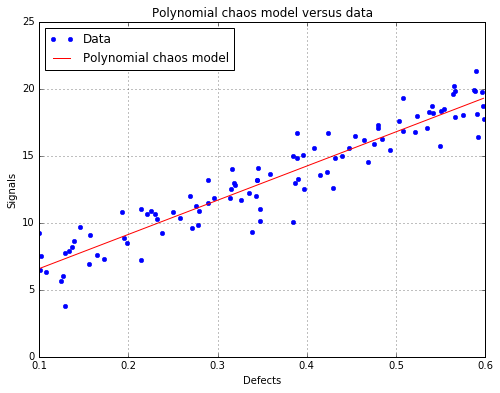

In [13]:
fig, ax = POD.drawPolynomialChaosModel()
fig.show()

## Advanced user mode

The user can defined one or all parameters of the polynomial chaos algorithm : 
- the distribution of the input parameters
- the adaptive strategy
- the projection strategy

In [14]:
# new POD study
PODnew = otpod.PolynomialChaosPOD(defects, signals, detection,
                               boxCox=True)

In [15]:
# define the input parameter distribution
distribution = ot.ComposedDistribution([ot.Normal(0.3, 0.1)])
PODnew.setDistribution(distribution)

In [16]:
# define the adaptive strategy
polyCol = [ot.HermiteFactory()]
enumerateFunction = ot.EnumerateFunction(1)
multivariateBasis = ot.OrthogonalProductPolynomialFactory(polyCol, enumerateFunction)
# degree 1
p = 1
indexMax = enumerateFunction.getStrataCumulatedCardinal(p)
adaptiveStrategy = ot.FixedStrategy(multivariateBasis, indexMax)

PODnew.setAdaptiveStrategy(adaptiveStrategy)

In [17]:
# define the projection strategy
projectionStrategy = ot.LeastSquaresStrategy()
PODnew.setProjectionStrategy(projectionStrategy)

In [18]:
PODnew.run()

Start build polynomial chaos model...
Polynomial chaos model completed
R2 : 0.8947
Q2 : 0.8914
Computing POD per defect: [==================================================] 100.00% Done


In [19]:
print PODnew.computeDetectionSize(0.9, 0.95)
print 'R2 : {:0.4f}'.format(POD.getR2())
print 'Q2 : {:0.4f}'.format(POD.getQ2())

[a90 : 0.303335, a90/95 : 0.315078]
R2 : 0.8947
Q2 : 0.8914


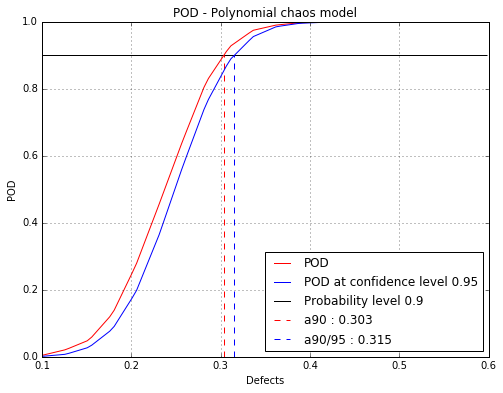

In [20]:
fig, ax = PODnew.drawPOD(probabilityLevel=0.9, confidenceLevel=0.95)
fig.show()

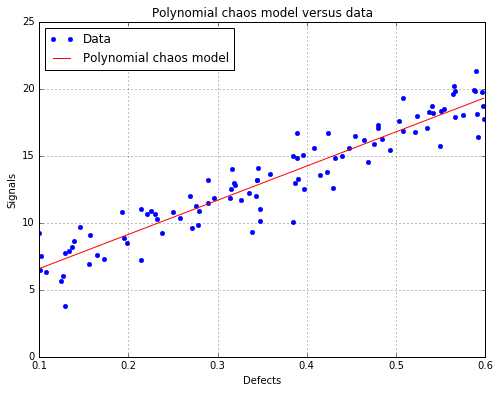

In [21]:
fig, ax = PODnew.drawPolynomialChaosModel()
fig.show()